### **TEMPO formaldehyde validation**

This notebook illustrates comparison of TEMPO formaldehyde total column retrievals with Pandora ground stations.

It allows a user to choose Pandora station of interest. Since TEMPO spatial coverage is regional and limited to North America, it is user's responsibilty to select the station within TEMPO's field of regard (FOR). If the selected station is outside FOR, no TEMPO time series will be generated.

The user is allowed to choose the time period of interest by providing start and end dates in the form YYYYMMDD. Please be aware, that if the selecte period of interest is outside of available time span of one of the sensors, corresponding time series will not be generated.

Data files for both sensors are downloaded on-the-fly. TEMPO data are downloaded with earthaccess library that needs to be installed first.

TEMPO data files are read by means of netCDF library that needs to be installed first.

Pandora data files are ASCII files with header and space separated columns. Custome made function is included to read nitrogen dioxide total column along with its total uncertainty.

This code takes into account quality flags (QFs) from both TEMPO and Pandora. This is implemented as follow. On the TEMPO side, data set "/product/main_data_quality_flag" is read, all pixels with non-zero QFs are discarded, however negative values of total HCHO column are NOT discarded and used for averaging/interpolationg to the point of interest. For the purpose of physical sanity, another way is also implemented, i.e., negative retrievals are not used in averaging. Therefore, TWO values are returned, total_HCHO_col, and total_HCHO_col_noneg. On Pandora side negative columns also occur despite high quality flags, though they are rare. So, two Pandora time series are considered - with and without negative columns.

The resulting time series are plotted with and without uncertainty of both measurement in the end of the notebook.

This notebook is tested on TEMPO_HCHO_L2_V03 and Pandora L2_rfus5p1-8 files.

# 1 Installing and importing necessary libraries

## 1.1 Installing netCDF

In [1]:
# un-comment if installation is necessary
#! pip3 install netCDF4

## 1.2 Installing earthaccess

In [2]:
# un-comment if installation is necessary
#! pip3 install earthaccess

## 1.3 Importing necessary libraries

In [1]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data

import os
import sys

import platform
from subprocess import Popen
import shutil

from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest
from scipy import stats # needed for linear regression analysis

import requests # needed to search for and download Pandora data
import codecs # needed to read Pandora data
import numpy as np
import matplotlib.pyplot as plt # needed to plot the resulting time series
from urllib.request import urlopen # needed to search for and download Pandora data
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime # needed to work with time in plotting time series

# 2 Defining functions to work with Pandora and TEMPO data

## 2.1 functions to work with Pandora

### 2.1.1 function creating the list of available Pandora sites

In [2]:
# function read_pandora_web returns the list of available Pandora sites
def read_pandora_web():
  url = 'https://data.pandonia-global-network.org/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  refs = []
  for line in ref_lines:
    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and line[pos1+1] == '.':
      refs.append(line[pos1+3 : pos2-1])

  return refs

### 2.1.2 functions allowing user to choose a Pandora site of interest

In [3]:
# function check_site checks whether user entered site is in the list of available Pandora sites
def check_site(site_name, refs):
  site_list = []
  for line in refs:
    if site_name in line:
      site_list.append(line)

  return site_list


# function take_pandora_sites takes user input and checks whether the site is in the list of available Pandora sites
def take_pandora_sites(refs):
  print('please select a Pandora site name from the list')
  for ref in refs:
    print(ref)

  answer = 'y'
  while answer == 'y':
    site_name = input('Enter a name of a Pandora site: ')
    print(site_name)
    site_list = check_site(site_name, refs)
    site_num = len(site_list)
    if site_num == 0:
      print('site ', site_name, 'was not found')
      continue

    if site_num > 1:
      print('there are ', site_num, ' site names, select one from')
      for site in site_list: print(site)

      site_name = input('Enter an exact name of a Pandora site: ')
      if site_list.count(site_name) != 1:
        print('Entered name is not the exact match of one of the following sites')
        for site in site_list: print(site)
        print('program terminated')
        sys.exit()

      for site in site_list:
        if site == site_name:
          pandora_site = site_name
          print('site ', site_name, 'was found and added to the list of sites ')
          break

    if site_num == 1:
      pandora_site = site_list[0]
      print('site ', site_list[0], 'was found and added to the list of sites ')

    answer = 'n'

  return pandora_site

### 2.1.3 function creating the list of links to formaldehyde data files at the selected Pandora sites and downloading the data files

In [4]:
# Pandora site may have several instruments. In this case each instrument has its own directory.
# However, the most recent version of the HCHO data, rfus5p1-8, is available only in one of these directories.
# The function creates all possible links, but some of them may be non-existing. This is checked and cleared later.
def instrument_path(site):
# function instrument_path returns links to available Pandora HCHO retrievals files
  url = 'https://data.pandonia-global-network.org/' + site + '/'
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")

  big_line = str(html)
  lines = big_line.split('\n')

  ref_lines = [i for i in lines if 'href' in i]
  links = []
  for line in ref_lines:

    pos1 = line.find('"')
    pos2 = line.rfind('"')
    if pos1 > 0 and pos2 > pos1 and line[pos2-1] =='/' and\
       line[pos1+3 : pos1 + 10] == 'Pandora':
      link = url + line[pos1+3 : pos2] + 'L2/' + line[pos1+3 : pos2-1] + '_' + site + '_L2_rfus5p1-8.txt'
      print(link)
      links.append(link)

  return links


# function downloading Pandora data file with given url
def download(url):
  response = requests.get(url)
  response_code = response.status_code

  file_name = url.split('/')[-1]

  if response_code == 200:
    content = response.content
    data_path = Path(file_name)
    data_path.write_bytes(content)

  return file_name, response_code

### 2.1.4 function reading Pandora NCHO data file rfus5p1-8

In [5]:
# function converting Pandora timestamp into a set of  year, month, day, hour, minute, and second
# function read_timestamp converts Pandora timestamp of the format
# 'yyyymmddThhmmssZ' into a set of 6 numbers:
# integer year, month, day, hour, minute, and real second.
def read_timestamp(timestamp):

  yyyy = int(timestamp[0:4])
  mm = int(timestamp[4:6])
  dd = int(timestamp[6:8])
  hh = int(timestamp[9:11])
  mn = int(timestamp[11:13])
  ss = float(timestamp[13:17])

  return yyyy, mm, dd, hh, mn, ss


# function reading Pandora NCHO data file rfus5p1-8
#
# Below is the second version of function read_Pandora_HCHO_rfus5p1_8. It is to be used for the future validation efforts.
# The difference with the original version is that instead of discriminating negative values of the total HCHO column,
# it uses quality flags. It was previously found that QF == 0 does not occure often enough,
# so we will have to use QF == 10 (not-assured high quality).
#
# function read_Pandora_HCHO_rfus5p1_8 reads Pandora total HCHO column data files ending with rfus5p1-8.
# Arguments:
# fname - name file to be read, string;
# start_date - beginning of the time interval of interest,
#              integer of the form YYYYMMDD;
# end_date -   end of the time interval of interest,
#              integer of the form YYYYMMDD.
#
# if start_date is greater than end_date, the function returns a numpy array
# with shape (0, 8), otherwise it returns an 8-column numpy array
# with with columns being year, month, day, hour, minute, second of observation
# and retrieved total HCHO column along with its total uncertainty.
#
# HCHO column is in mol/m^2, so conversion to molecules/cm^2 is performed by
# multiplication by Avogadro constant, NA =  6.02214076E+23, and division by 1.E+4
def read_Pandora_HCHO_rfus5p1_8_v2(fname, start_date, end_date):

  conversion_coeff = 6.02214076E+19 # Avogadro constant divided by 10000

  data = np.empty([0, 8])
  if start_date > end_date: return -999., -999., 'no_name', data

  with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:

    while True:
# Get next line from file
      line = f.readline()

      if line.find('Short location name:') >= 0:
        loc_name = line.split()[-1] # location name, to be used in the output file name
        print('location name ', loc_name)

      if line.find('Location latitude [deg]:') >= 0:
        lat = float(line.split()[-1]) # location latitude
        print('location latitude ', lat)

      if line.find('Location longitude [deg]:') >= 0:
        lon = float(line.split()[-1]) # location longitude
        print('location longitude ', lon)

      if line.find('--------') >= 0: break

    while True:
# Get next line from file
      line = f.readline()

      if line.find('--------') >= 0: break

    while True:
# now reading line with data
      line = f.readline()

      if not line: break

      line_split = line.split()

      yyyy, mm, dd, hh, mn, ss = read_timestamp(line_split[0])
      date_stamp = yyyy*10000 + mm*100 + dd
      if date_stamp < start_date or date_stamp > end_date: continue

      QF = int(line_split[35]) # total column uncertainty

      if QF == 0 or QF == 10:
        column = float(line_split[38])
        column_unc = float(line_split[42]) # total column uncertainty
        data = np.append(data, [[yyyy, mm, dd, hh, mn, ss\
                               , column*conversion_coeff\
                               , column_unc*conversion_coeff]], axis = 0)

  return lat, lon, loc_name, data

## 2.2 function reading TEMPO HCHO data file

In [6]:
# function reading TEMPO HCHO data file
def read_TEMPO_HCHO_L2(fn):
  '''
  function read_TEMPO_HCHO_L2 reads the following arrays from the
  TEMPO L2 HCHO product TEMPO_HCHO_L2_V03:
    main_data_quality_flag
    vertical_column;
    vertical_column_uncertainty;
  and returns respective fields along with coordinates of the pixels.

  If one requested variables cannot be read, all returned variables are zeroed
  '''
  var_name = 'vertical_column'
  var_unc_name = 'vertical_column_uncertainty'
  var_QF_name = 'main_data_quality_flag'

  try:
    ds = nc.Dataset(fn)

    prod = ds.groups['product'] # this opens group product, /product, as prod

    var = prod.variables[var_name] # this reads variable vertical_column from prod (group product, /product)
    total_HCHO_column = np.array(var)
    fv_prod = var.getncattr('_FillValue')
    prod_unit = var.getncattr('units')

    var_unc = prod.variables[var_unc_name] # this reads variable vertical_column_uncertainty from prod (group product, /product)
    total_HCHO_column_unc = np.array(var_unc)

    var_QF = prod.variables[var_QF_name] # this reads variable main_data_quality_flag from prod (group product, /product)
    total_HCHO_column_QF = np.array(var_QF)
    fv_QF = var_QF.getncattr('_FillValue')

    geo = ds.groups['geolocation'] # this opens group geolocation, /geolocation, as geo

    lat = np.array(geo.variables['latitude']) # this reads variable latitude from geo (geolocation group, /geolocation) into a numpy array
    lon = np.array(geo.variables['longitude']) # this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array
    fv_geo = geo.variables['latitude'].getncattr('_FillValue')
    time = np.array(geo.variables['time'] )# this reads variable longitude from geo (geolocation group, /geolocation) into a numpy array

    ds.close()

  except:
    print('variable '+var_name+' cannot be read in file '+fn)
    lat = 0.
    lon = 0.
    time = 0.
    fv_geo = 0.
    total_HCHO_column = 0.
    total_HCHO_column_unc = 0.
    total_HCHO_column_QF = 0.
    fv_prod = 0.
    fv_QF = -999
    prod_unit = ''

  return lat, lon, fv_geo, time, total_HCHO_column, total_HCHO_column_unc\
, total_HCHO_column_QF, fv_prod, fv_QF, prod_unit

## 2.3 auxiliary functions to handle data

### 2.3.1 function smoothing Pandora retievals and interpolating them onto TEMPO times of observations

In [7]:
# Pandora timeseries has significantly more data points then TEMPO and DSCOVR. It is also very noisy.
# To make comparison easier, Pandora timeseries is interpolated to the moments of TEMPO observations.
#
# Interpolation is performed by the function defined below with the help of Gaussian smooting as follow:
# x_int(t) = SUM(x_p(t_i)*wt(t_i, t)),
#
# wt(t_i, t) = exp(-(t - t_i)^2/(2 * sigma^2))/SUM(exp(-(t - t_i)^2/(2 * sigma^2))),
#
# where sums are taken over times t_i falling into time interval (t-dt_max, t+dt_max).
#
# Parameters dt_max and sigma can be chosen by the user.
def gauss_interpolation(timeseries, new_times):
#
# function gauss_interpolation takes 2D array timeseries with function
# to be interpolated and 1D array new_times containing times to which
# the function is to be interpolated
# arguments:
#     timeseries - array with at least 2 columns,
#                  1st column - times, 2nd (3rd, ...) column(s) - function to be interpolated
#     new_times  - 1D array of times to which the function(s) to be interpolated
#
# parameters
# dt_max = 0.00375 - 324 seconds expressed in days
# sigma = 0.00125 - 81 seconds expressed in days

  dt_max = 0.00375 # 324 seconds expressed in days
  sigma = 0.00125 # 81 seconds expressed in days

  nnt = len(new_times)
  (nt, nfun) = timeseries.shape

  timeseries_smooth = np.empty([0, nfun])
  data_subset = np.empty(nnt, dtype = object)
  cnt = 0
  for new_time in new_times:
    llim = new_time - dt_max
    ulim = new_time + dt_max

    timeseries_subset = timeseries[((timeseries[:, 0] < ulim)\
                                    & (timeseries[:, 0] > llim))]
    if len(timeseries_subset) < 1: continue
    t_delta = timeseries_subset[:, 0] - new_time
    wt = np.exp(-t_delta**2/(2.*sigma**2))
    wt = wt/np.sum(wt)
    timeseries_subset = np.append(timeseries_subset, np.transpose([wt]), axis = 1)
    for t in timeseries_subset: print(f'{t[0]:.5f} {t[1]:.3e} {t[2]:.2e} {t[3]:.4e}')
    data_subset[cnt] = timeseries_subset
    cnt += 1

    timeseries_smooth_loc = np.array([new_time])
    for ifun in range(1, nfun):
      timeseries_smooth_loc = np.append(timeseries_smooth_loc,\
                                        np.sum(timeseries_subset[:, ifun]*wt))
    print(f'{timeseries_smooth_loc[0]:.5f} {timeseries_smooth_loc[1]:.3e} {timeseries_smooth_loc[2]:.2e}\n')

    timeseries_smooth = np.append(timeseries_smooth,\
                                  np.array([timeseries_smooth_loc]), axis = 0)

  return timeseries_smooth, data_subset

### 2.3.2 function computing linear regression with zero intercept

In [8]:
# custom made function regress_0intercept takes vectors x and y
# representing coordinates and function values at these coordinates
# and returns slope of regression fit y = a*x
# along with coefficient of determination
def regress_0intercept(x, y):
  success = False

  if len(x) != len(y):
    a = 0.
    R2 = 0.

  elif len(x) == 1:
    if x[0] != 0.:
      a = y[0]/x[0]
      R2 = 1.
      success = True
    else:
      if y[0] != 0.:
        a = np.inf
        R2 = 1.
        success = True
      else:
        a = np.inf
        R2 = 0.

  else:
    xy_sum = np.dot(x, y)
    x2_sum = np.dot(x, x)
    a = xy_sum/x2_sum

    res_y = y - a*x
    res_sum_2 = np.dot(res_y, res_y)
    y2_sum = np.dot(y, y)
    sum_tot_2 = y2_sum - len(y)*np.mean(y)**2
    R2 = 1. - res_sum_2/sum_tot_2

    success = True

  return success, a, R2

# Main code begins here

# 3 Establishing access to EarthData

## 3.1 Logging in

In [9]:
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

## 3.2 Creating local directory

In [10]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /home/jovyan/


# 4 Working with Pandora data

## 4.1 Discovering existing Pandora stations and selecting one of them

In [11]:
# Discovering existing Pandora stations and selecting one of them
# Discovering available Pandora site.
# Please bear in mind that some sites do not have HCHO data files
print('gathering Pandora sites information')
refs = read_pandora_web()

pandora_site = take_pandora_sites(refs) # create list of Pandora sites of interest
print('the following sites were selected')
print(pandora_site)
print('from the list of existing Pandora sites')

# create a list of !AVAILABLE! Pandora files for the Pandora site
pandora_files = []

links = instrument_path(pandora_site)

npfiles = 0

for link in links:
  pandora_fname = link.split('/')[-1]

# check if file exists in the local directory, if not download from Pandora site
  if not os.path.exists(pandora_fname):
    print(pandora_fname,' does not exit in local directory, downloading from the web')
    print(link)

    pandora_fname, response_code = download(link)

    if response_code == 200:
      print('Pandora L2 file ', pandora_fname, ' has been downloaded')
      npfiles = npfiles + 1
      pandora_files.append(pandora_fname)
    else:
      print('Pandora L2 file ', link, ' does not exist')

  else:
    print(pandora_fname,' exits in local directory')
    npfiles = npfiles + 1
    pandora_files.append(pandora_fname)

if npfiles == 0: # no files were found, STOP here
  print('no files were found for Pandora site ', pandora_site, 'program terminated')
  sys.exit()
if npfiles > 1: # normally there should be only one file per site. if there are more - STOP
  print('there are too many files for site ', pandora_site, '- STOP and investigate file names below. Program terminated')
  for pandora_fname in pandora_files:
    print(pandora_fname)
  sys.exit()

gathering Pandora sites information
please select a Pandora site name from the list
Agam
AldineTX
AliceSprings
Altzomoni
ArlingtonTX
Athens-NOA
AtlantaGA-Conyers
AtlantaGA-GATech
AtlantaGA-SouthDeKalb
AtlantaGA
AustinTX
Bandung
Bangkok
Banting
BayonneNJ
Beijing-RADI
BeltsvilleMD
Berlin
BlueHillMA
BostonMA
BoulderCO-NCAR
BoulderCO
Bremen
BristolPA
BronxNY
Brussels-Uccle
Bucharest
BuenosAires
BuffaloNY
Busan
Cabauw
Calakmul
calibrationfiles
CambridgeBay
CambridgeMA
CameronLA
CapeElizabethME
Cebu
ChapelHillNC
CharlesCityVA
ChelseaMA
ChiangMai
ChicagoIL
Cologne
ComodoroRivadavia
Cordoba
CornwallCT
CorpusChristiTX
Daegu
Dalanzadgad
Davos
DearbornMI
DeBilt
Dhaka
Downsview
EastProvidenceRI
EdwardsCA
Egbert
EssexMD
Eureka-0PAL
Eureka-PEARL
FairbanksAK
Fajardo
FortMcKay
FortYatesND
Fukuoka
Gongju-KNU
Granada
GrandForksND
GreenbeltMD
Haldwani-ARIES
HamptonVA-HU
HamptonVA
Heidelberg
Helsinki
HoustonTX-SanJacinto
HoustonTX
HuntsvilleAL
Ilocos
Incheon-ESC
Innsbruck
IowaCityIA-WHS
Islamabad-NUST
Iza

Enter a name of a Pandora site:  Mex


Mex
there are  2  site names, select one from
MexicoCity-UNAM
MexicoCity-Vallejo


Enter an exact name of a Pandora site:  MexicoCity-UNAM


site  MexicoCity-UNAM was found and added to the list of sites 
the following sites were selected
MexicoCity-UNAM
from the list of existing Pandora sites
https://data.pandonia-global-network.org/MexicoCity-UNAM/Pandora142s1/L2/Pandora142s1_MexicoCity-UNAM_L2_rfus5p1-8.txt
Pandora142s1_MexicoCity-UNAM_L2_rfus5p1-8.txt  does not exit in local directory, downloading from the web
https://data.pandonia-global-network.org/MexicoCity-UNAM/Pandora142s1/L2/Pandora142s1_MexicoCity-UNAM_L2_rfus5p1-8.txt
Pandora L2 file  Pandora142s1_MexicoCity-UNAM_L2_rfus5p1-8.txt  has been downloaded


## 4.2 Selecting timeframe of interest common for both instruments

In [12]:
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp_ini = input('enter start date of interest ')
datestamp_fin = input('enter end date of interest ')

start_date = int(datestamp_ini)
end_date = int(datestamp_fin)

yyyy_ini = start_date//10000
mm_ini = (start_date//100 - yyyy_ini*100)
dd_ini = (start_date - yyyy_ini*10000 - mm_ini*100)

yyyy_fin = end_date//10000
mm_fin = (end_date//100 - yyyy_fin*100)
dd_fin = (end_date - yyyy_fin*10000 - mm_fin*100)
print(yyyy_ini, mm_ini, dd_ini, yyyy_fin, mm_fin, dd_fin)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy_ini, mm_ini, dd_ini))
date_end = str('%4.4i-%2.2i-%2.2i 23:59:59' %(yyyy_fin, mm_fin, dd_fin))

enter period of interest, start and end dates, in the form YYYYMMDD


enter start date of interest  20230904
enter end date of interest  20230904


2023 9 4 2023 9 4


## 4.3 Reading Pandora file within selected timeframe and creating point of interest

In [13]:
pandora_file = pandora_files[0]
lat, lon, POI_name, Pandora_data = read_Pandora_HCHO_rfus5p1_8_v2(pandora_file, start_date, end_date)

if lat == -999.:
  print('error reading pandora file ', pandora_file, 'program terminated')
  sys.exit()

POI = np.array([lat, lon])

# print # of points in Pandora timeseries
n_Pandora_data = len(Pandora_data)
print(n_Pandora_data,\
' Pandora measurements found within period of interes between',\
date_start, 'and', date_end)
if n_Pandora_data == 0:
  print('There are no Pandora observations with quality flags 0 or 10,\n'\
+'user should stop here unless plotting TEMPO-only time series is needed')

location name  MexicoCity-UNAM
location latitude  19.3262
location longitude  -99.1761
21  Pandora measurements found within period of interes between 2023-09-04 00:00:00 and 2023-09-04 23:59:59


## 4.4 Setting TEMPO name constants and writing Pandora timeseries to a file

In [15]:
# Setting TEMPO name constants
short_name = 'TEMPO_HCHO_L2' # collection name to search for in the EarthData
out_Q = 'HCHO_tot_col' # name of the output quantity with unit
out_Q_unit = 'molecules/cm^2' # name of the output quantity with unit

# write Pandora timeseries to a file
POI_name_ = POI_name.replace(' ','_')
Pandora_out = open(out_Q+'_Pandora_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
for line in Pandora_data:
  Pandora_out.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %12.4e %12.4e\n'\
 %(line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7])))
Pandora_out.close()

# 5 Working with TEMPO data

## 5.1 Searching TEMPO data files containing the POI (position of the Pandora station)

In [16]:
# Searching TEMPO data files within 0.5 degree range around the POI (position of the Pandora station)
POI_lat = POI[0]
POI_lon = POI[1]

version = 'V03'
POI_results = earthaccess.search_data(short_name = short_name\
                                    , version = version\
                                    , temporal = (date_start, date_end)\
                                    , point = (POI_lon, POI_lat))

n_gr = len(POI_results)
if n_gr == 0:
  print('program terminated')
  print('There are no TEMPO granules covering the selected\n'\
+'Pandora station withing selected timeframe, user should stop here\n'\
+'unless plotting TEMPO-only time series is needed')

Granules found: 14


## 5.2 Printing explicit links to the granules and downloading the files

In [19]:
granule_links = []
for result in POI_results: granule_links.append(result['umm']['RelatedUrls'][0]['URL'])
for granule_link in granule_links: print(granule_link)

# Downloading TEMPO data files
downloaded_files = earthaccess.download(
    POI_results,
    local_path='.')

# Checking whether all TEMPO data files have been downloaded
for granule_link in granule_links:
  TEMPO_fname = granule_link.split('/')[-1]
# check if file exists in the local directory
  if not os.path.exists(TEMPO_fname):
    print(TEMPO_fname, 'does not exist in local directory')
# repeat attempt to download
    downloaded_files = earthaccess.download(granule_link,
                                            local_path='.')
# if file still does not exist in the directory, remove its link from the list of links
    if not os.path.exists(TEMPO_fname): granule_links.remove(granule_link)

https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T000424Z_S018G02.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T003547Z_S019G02.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T010710Z_S020G02.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T144052Z_S007G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T154323Z_S008G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T164554Z_S009G07.nc
https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_HCHO_L2_V03/2023.09.04/TEMPO_HCHO_L2_V03_20230904T174825Z_S010G07.nc
https://data.asdc.earthdata.nasa.g

## 5.3 Compiling TEMPO formaldehyde column time series

In [20]:
# Important note
# HCHO total column may be negative even with the highest quality flag.
# The code below compiles TWO timeseries one takes all values of total NO2 column,
# while another discards negative values before interpolation to the POI is performed.
# The two timeseries will be plotted later to see the difference, if any.
# This feature may be commented out should the user be not interested in accounting positive-only retrievals.

days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

fout_noFV = open(out_Q+'_noFV_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout_noFV.write('timeseries of '+out_Q+' at '\
+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout_noFV.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

fout_noneg = open(out_Q+'_noneg_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'w')
fout_noneg.write('timeseries of '+out_Q+' at '\
+POI_name+' '+str('%08.4fN %08.4fW' %(POI[0], -POI[1]))+'\n')
fout_noneg.write('yyyy mm dd hh mn ss '+out_Q_unit+'\n')

for granule_link in granule_links:
  last_slash_ind = granule_link.rfind('/')
  fname = granule_link[last_slash_ind+1 : ]
  print('\n', fname)

  lat, lon, fv_geo, time, total_HCHO_column, total_HCHO_column_unc,\
total_HCHO_column_QF, fv_prod, fv_QF, prod_unit = read_TEMPO_HCHO_L2(fname)
# un-comment the line below if TEMPO granules are not needed after processing
#  os.remove(fname)

  if isinstance(lat, float): continue

  nx = lon.shape[0]
  ny = lon.shape[1]

# getting time from the granule filename
  Tind = fname.rfind('T')
  yyyy= int(fname[Tind-8 : Tind-4])
  mm = int(fname[Tind-4 : Tind-2])
  dd = int(fname[Tind-2 : Tind])
  hh = int(fname[Tind+1 : Tind+3])
  mn = int(fname[Tind+3 : Tind+5])
  ss = float(fname[Tind+5 : Tind+7])

# check whether POI is in the granule. If not - move to the next granule
  pp = np.array([POI[1], POI[0]])
  p = Point(pp) # POI[0] - latitudes, POI[1] - longitudes
#  if not p.within(poly):
#    print('point', POI[0], POI[1], 'is not within the granule polygon' )
#    continue
#  print('point', POI[0], POI[1], 'is within the granule polygon' )

  POI_found = False
  for ix in range(nx-1):
    for iy in range(ny-1):
      if lon[ix, iy] == fv_geo: continue
      if lat[ix, iy] == fv_geo: continue
      if lon[ix, iy+1] == fv_geo: continue
      if lat[ix, iy+1] == fv_geo: continue
      if lon[ix+1, iy+1] == fv_geo: continue
      if lat[ix+1, iy+1] == fv_geo: continue
      if lon[ix+1, iy] == fv_geo: continue
      if lat[ix+1, iy] == fv_geo: continue

      coords_poly_loc = [[lon[ix, iy], lat[ix, iy]], [lon[ix, iy+1], lat[ix, iy+1]] \
                   , [lon[ix+1, iy+1], lat[ix+1, iy+1]], [lon[ix+1, iy], lat[ix+1, iy]]]
      poly_loc = Polygon(coords_poly_loc)

      if p.within(poly_loc):
        print('scanl pixel latitude    longitude   totHCHO_col totHCHO_col_unc totHCHO_col_QF')
        for scl in range(ix, ix+2, 1):
          for pix in range(iy, iy+2, 1):
            print("  %3d  %4d %9.6f %10.6f   %11.4e     %11.4e %5i"\
 %(scl, pix, lat[scl, pix], lon[scl, pix]\
, total_HCHO_column[scl, pix], total_HCHO_column_unc[scl, pix], total_HCHO_column_QF[scl, pix]))

        POI_found = True
        print('POI', POI_name, 'at', POI[0], POI[1], ' found')

        total_HCHO_column_loc = np.array([total_HCHO_column[ix, iy],\
                                         total_HCHO_column[ix, iy+1],\
                                         total_HCHO_column[ix+1, iy+1],\
                                         total_HCHO_column[ix+1, iy]])
        total_HCHO_column_unc_loc = np.array([total_HCHO_column_unc[ix, iy],\
                                             total_HCHO_column_unc[ix, iy+1],\
                                             total_HCHO_column_unc[ix+1, iy+1],\
                                             total_HCHO_column_unc[ix+1, iy]])
        total_HCHO_column_QF_loc = np.array([total_HCHO_column_QF[ix, iy],\
                                            total_HCHO_column_QF[ix, iy+1],\
                                            total_HCHO_column_QF[ix+1, iy+1],\
                                            total_HCHO_column_QF[ix+1, iy]])
        lat_loc = np.array([lat[ix, iy], lat[ix, iy+1],\
                            lat[ix+1, iy+1], lat[ix+1, iy]])
        lon_loc = np.array([lon[ix, iy], lon[ix, iy+1],\
                            lon[ix+1, iy+1], lon[ix+1, iy]])
        mask_noFV  = (total_HCHO_column_loc != fv_prod)&\
                     (total_HCHO_column_unc_loc != fv_prod)&\
                     (total_HCHO_column_QF_loc == 0)
        mask_noneg = (total_HCHO_column_loc > 0.)&\
                     (total_HCHO_column_unc_loc != fv_prod)&\
                     (total_HCHO_column_QF_loc == 0)

        points_noFV  = np.column_stack((lon_loc[mask_noFV], lat_loc[mask_noFV]))
        points_noneg = np.column_stack((lon_loc[mask_noneg], lat_loc[mask_noneg]))
        ff_noFV  = total_HCHO_column_loc[mask_noFV]
        ff_noneg = total_HCHO_column_loc[mask_noneg]
        ff_unc_noFV  = total_HCHO_column_unc_loc[mask_noFV]
        ff_unc_noneg = total_HCHO_column_unc_loc[mask_noneg]

# handling time first:
        delta_t = (time[ix+1] + time[ix])*0.5 - time[0]
        ss = ss + delta_t
        if ss >= 60.:
          delta_mn = int(ss/60.)
          ss = ss - 60.*delta_mn
          mn = mn + delta_mn
          if mn >= 60:
            mn = mn - 60
            hh = hh + 1
            if hh == 24:
              hh = hh - 24
              dd = dd + 1
              day_month = days[mm]
              if (yyyy//4)*4 == yyyy and mm == 2: day_month = day_month + 1
              if dd > day_month:
                dd = 1
                mm = mm + 1
                if mm > 12:
                  mm = 1
                  yyyy = yyyy + 1

        if ff_noFV.shape[0] == 0:
          continue
        elif ff_noFV.shape[0] < 4:
          total_HCHO_column_noFV = np.mean(ff_noFV)
          total_HCHO_column_unc_noFV = np.mean(ff_unc_noFV)
        elif ff_noFV.shape[0] == 4:
          total_HCHO_column_noFV = griddata(points_noFV, ff_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]
          total_HCHO_column_unc_noFV = griddata(points_noFV, ff_unc_noFV, pp,\
method='linear', fill_value=-1., rescale=False)[0]

        fout_noFV.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %10.3e %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, total_HCHO_column_noFV, total_HCHO_column_unc_noFV)))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy], -lon[ix, iy],\
total_HCHO_column[ix, iy], total_HCHO_column_unc[ix, iy])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1],\
total_HCHO_column[ix, iy+1], total_HCHO_column_unc[ix, iy+1])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1],\
total_HCHO_column[ix+1, iy+1], total_HCHO_column_unc[ix+1, iy+1])))
        fout_noFV.write(str('%9.4fN %9.4fW %10.3e %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy],\
total_HCHO_column[ix+1, iy], total_HCHO_column_unc[ix+1, iy])))

        if ff_noneg.shape[0] == 0:
          continue
        elif ff_noneg.shape[0] < 4:
          total_HCHO_column_noneg = np.mean(ff_noneg)
          total_HCHO_column_unc_noneg = np.mean(ff_unc_noneg)
        elif ff_noneg.shape[0] == 4:
          total_HCHO_column_noneg = griddata(points_noneg, ff_noneg, pp,\
method='linear', fill_value=-1., rescale=False)[0]
          total_HCHO_column_unc_noneg = griddata(points_noneg, ff_unc_noneg, pp,\
method='linear', fill_value=-1., rescale=False)[0]

        fout_noneg.write(str('%4.4i %2.2i %2.2i %2.2i %2.2i %4.1f %10.3e %10.3e '\
 %(yyyy, mm, dd, hh, mn, ss, total_HCHO_column_noneg, total_HCHO_column_unc_noneg)))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy], -lon[ix, iy],\
total_HCHO_column[ix, iy], total_HCHO_column_unc[ix, iy])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix, iy+1], -lon[ix, iy+1],\
total_HCHO_column[ix, iy+1], total_HCHO_column_unc[ix, iy+1])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e '\
 %(lat[ix+1, iy+1], -lon[ix+1, iy+1],\
total_HCHO_column[ix+1, iy+1], total_HCHO_column_unc[ix+1, iy+1])))
        fout_noneg.write(str('%9.4fN %9.4fW %10.3e %10.3e\n'\
 %(lat[ix+1, iy], -lon[ix+1, iy],\
total_HCHO_column[ix+1, iy], total_HCHO_column_unc[ix+1, iy])))

        break

    if POI_found: break

fout_noFV.close()
fout_noneg.close()


 TEMPO_HCHO_L2_V03_20230904T000424Z_S018G02.nc
scanl pixel latitude    longitude   totHCHO_col totHCHO_col_unc totHCHO_col_QF
   56  1907 19.331041 -99.135368   -4.5987e+16      3.6250e+16     1
   56  1908 19.316168 -99.134552    2.2521e+15      6.3149e+16     1
   57  1907 19.331553 -99.178902    4.0344e+16      3.3803e+16     1
   57  1908 19.316607 -99.178047    4.0999e+16      2.7387e+16     1
POI MexicoCity-UNAM at 19.3262 -99.1761  found

 TEMPO_HCHO_L2_V03_20230904T003547Z_S019G02.nc
scanl pixel latitude    longitude   totHCHO_col totHCHO_col_unc totHCHO_col_QF
   56  1906 19.340015 -99.152893   -2.4181e+17      2.1879e+17     1
   56  1907 19.325111 -99.152069    1.1652e+17      3.7041e+17     1
   57  1906 19.340120 -99.196526    2.0689e+17      2.2333e+17     1
   57  1907 19.325216 -99.195679    2.3838e+17      2.9945e+17     1
POI MexicoCity-UNAM at 19.3262 -99.1761  found

 TEMPO_HCHO_L2_V03_20230904T010710Z_S020G02.nc
scanl pixel latitude    longitude   totHCHO_col totH

# 6 Plotting the results

## 6.1 Reading created data files for TEMPO, create timeseries

In [22]:
# reading TEMPO file that was created at the previous step
# only read POI information from the header and first 8 columns of data:
#   yyyy, mm, dd, hh, mn, ss, HCHO column, and its incertainty
fout = open(out_Q+'_noneg_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'r')

header1 = fout.readline()
header2 = fout.readline()
data_lines_noneg = fout.readlines()

fout.close()

yyyy = yyyy_ini
mm = mm_ini
dd = dd_ini
hh = 0
mn = 0
ss = 0
dt0 = datetime(yyyy, mm, dd, hh, mn, ss)

yyyy = yyyy_fin
mm = mm_fin
dd = dd_fin
hh = 23
mn = 59
ss = 59
dt_fin = datetime(yyyy, mm, dd, hh, mn, ss) # this is time 1 second before the end of the timeframe of interest

time_series_TEMPO_noneg = np.empty([0, 3])

for line in data_lines_noneg:
  split = line.split()
  yyyy = int(split[0])
  mm = int(split[1])
  dd = int(split[2])
  hh = int(split[3])
  mn = int(split[4])
  ss = float(split[5])
  us = int((ss - int(ss))*1000000) # microseconds
# dt below is time since the beginning of the period of interest in hours
  dt = (datetime(yyyy, mm, dd, hh, mn, int(ss), us) - dt0).total_seconds()/86400.
  time_series_TEMPO_noneg = np.append(time_series_TEMPO_noneg,\
 [[dt, float(split[6]), float(split[7])]], axis = 0)

fout = open(out_Q+'_noFV_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'r')

header1 = fout.readline()
header2 = fout.readline()
data_lines = fout.readlines()

fout.close()

time_series_TEMPO = np.empty([0, 3])

for line in data_lines:
  split = line.split()
  yyyy = int(split[0])
  mm = int(split[1])
  dd = int(split[2])
  hh = int(split[3])
  mn = int(split[4])
  ss = float(split[5])
  us = int((ss - int(ss))*1000000) # microseconds
# dt below is time since the beginning of the period of interest in hours
  dt = (datetime(yyyy, mm, dd, hh, mn, int(ss), us) - dt0).total_seconds()/86400.
  time_series_TEMPO = np.append(time_series_TEMPO,\
 [[dt, float(split[6]), float(split[7])]], axis = 0)

if len(time_series_TEMPO) == 0:
  print('Standard TEMPO time series is empty')
if len(time_series_TEMPO_noneg) == 0:
  print('TEMPO time series excluding negative HCHO retrievals is empty')

if len(time_series_TEMPO) == len(time_series_TEMPO_noneg):
  print('\nTEMPO standard and "no negative" are of equal length')
  nt = len(time_series_TEMPO)
  equal = True
  for i in range(nt):
    if time_series_TEMPO[i,1] != time_series_TEMPO_noneg[i,1]:
      equal = False
      break
else: equal = False

if equal: print('TEMPO standard and "no negative" are the same')
else: print('TEMPO standard and "no negative" are different')


TEMPO standard and "no negative" are of equal length
TEMPO standard and "no negative" are the same


## 6.2 creating Pandora timeseries

In [23]:
Pandora_out = open(out_Q+'_Pandora_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name_+'_'+str('%08.4fN_%08.4fW.txt' %(POI[0], -POI[1])), 'r')
Pandora_data_lines = Pandora_out.readlines()
Pandora_out.close()

time_series_Pandora = np.empty([0, 3])
time_series_Pandora_noneg = np.empty([0, 3])

for line in Pandora_data_lines:
  split = line.split()
  yyyy = int(split[0])
  mm = int(split[1])
  dd = int(split[2])
  hh = int(split[3])
  mn = int(split[4])
  ss = float(split[5])
  us = int((ss - int(ss))*1000000) # microseconds
# dt below is time since the beginning of the period of interest in hours
  dt = (datetime(yyyy, mm, dd, hh, mn, int(ss), us) - dt0).total_seconds()/86400.
  col = float(split[6])
  unc = float(split[7])
  time_series_Pandora = np.append(time_series_Pandora,\
[[dt, col, unc]], axis = 0)
  if col > 0:
    time_series_Pandora_noneg = np.append(time_series_Pandora_noneg,\
[[dt, col, unc]], axis = 0)

## 6.3 Plotting timeseries

### 6.3.1 No error bars

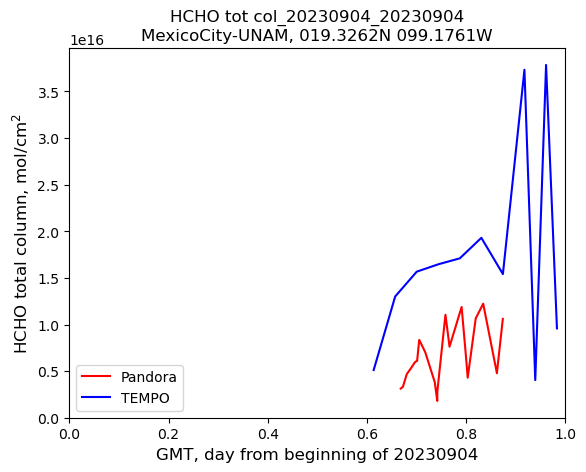

In [25]:
plot_title = out_Q.replace('_',' ')+'_'+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

plt.plot(time_series_Pandora[:, 0], time_series_Pandora[:, 1],\
         label = "Pandora", c = 'r')
plt.plot(time_series_TEMPO[:, 0], time_series_TEMPO[:, 1],
         label = "TEMPO", c = 'b')

# Set the range of x-axis
l_lim = 0.
u_lim = ((dt_fin - dt0).total_seconds() + 1.)/86400.
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel('HCHO total column, mol/cm$^{2}$', fontsize=12)

plt.legend(loc='lower left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

### 6.3.2 Plotting TEMPO and smoothed Pandora retievals with error bars

0.69723 5.981e+15 9.76e+14 3.8708e-02
0.70124 6.102e+15 1.01e+15 9.6129e-01
0.70049 6.097e+15 1.01e+15

0.74181 1.802e+15 1.12e+15 3.9982e-01
0.74214 2.884e+15 1.13e+15 6.0018e-01
0.74390 2.451e+15 1.12e+15

0.79094 1.188e+16 1.17e+15 1.0000e+00
0.78732 1.188e+16 1.17e+15

0.83447 1.223e+16 1.04e+15 1.0000e+00
0.83077 1.223e+16 1.04e+15

0.87404 1.060e+16 9.46e+14 1.0000e+00
0.87418 1.060e+16 9.46e+14

0.69723 5.981e+15 9.76e+14 3.8708e-02
0.70124 6.102e+15 1.01e+15 9.6129e-01
0.70049 6.097e+15 1.01e+15

0.74181 1.802e+15 1.12e+15 3.9982e-01
0.74214 2.884e+15 1.13e+15 6.0018e-01
0.74390 2.451e+15 1.12e+15

0.79094 1.188e+16 1.17e+15 1.0000e+00
0.78732 1.188e+16 1.17e+15

0.83447 1.223e+16 1.04e+15 1.0000e+00
0.83077 1.223e+16 1.04e+15

0.87404 1.060e+16 9.46e+14 1.0000e+00
0.87418 1.060e+16 9.46e+14



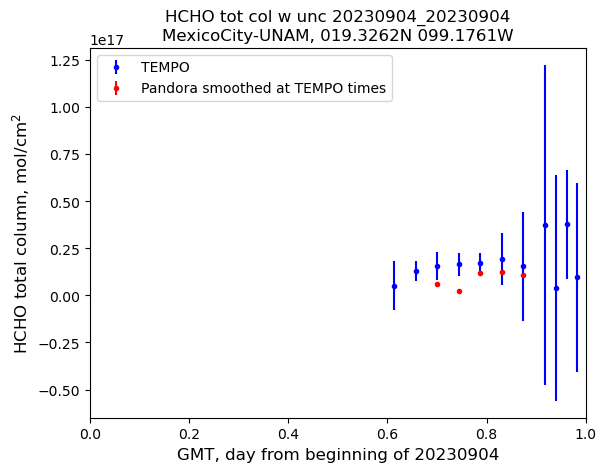

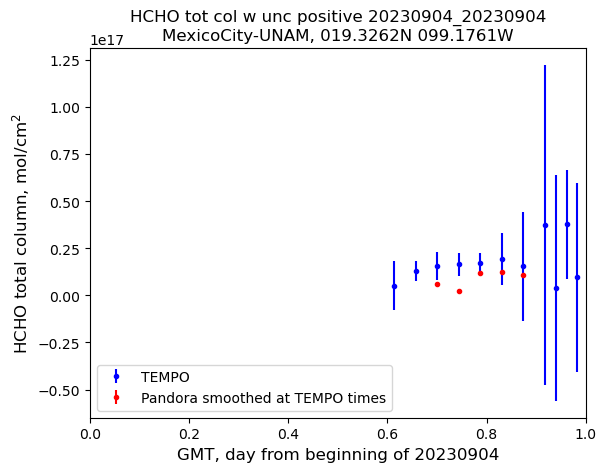

In [26]:
timeseries_Pandora_TEMPO, data_subset = gauss_interpolation(time_series_Pandora[:, 0:3]\
                                             , time_series_TEMPO[:, 0])

timeseries_Pandora_TEMPO_noneg, data_subset_noneg =\
 gauss_interpolation(time_series_Pandora_noneg[:, 0:3]\
                   , time_series_TEMPO_noneg[:, 0])

plot_title = out_Q.replace('_',' ')+' w unc '+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_unc_'+'_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(time_series_TEMPO[:, 0], time_series_TEMPO[:, 1],\
yerr=time_series_TEMPO[:, 2], label = "TEMPO", c = 'b', ls = '', marker = ".")

plt.errorbar(timeseries_Pandora_TEMPO[:, 0],\
             timeseries_Pandora_TEMPO[:, 1],\
             yerr=timeseries_Pandora_TEMPO[:, 2],\
             label = "Pandora smoothed at TEMPO times",\
             c = 'r', ls = '', marker = ".")

# Set the range of x-axis
l_lim = 0.
u_lim = ((dt_fin - dt0).total_seconds() + 1.)/86400.
plt.xlim(l_lim, u_lim)

# some research is required to set the vertical range
plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel('HCHO total column, mol/cm$^{2}$', fontsize=12)

#plt.legend(loc='lower left')
plt.legend(loc='upper left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

plot_title = out_Q.replace('_',' ')+' w unc positive '+datestamp_ini+'_'+datestamp_fin+'\n'+POI_name
img_name = out_Q+'_unc_positive_'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(time_series_TEMPO_noneg[:, 0], time_series_TEMPO_noneg[:, 1],\
yerr=time_series_TEMPO_noneg[:, 2], label = "TEMPO", c = 'b', ls = '', marker = ".")

plt.errorbar(timeseries_Pandora_TEMPO_noneg[:, 0],\
             timeseries_Pandora_TEMPO_noneg[:, 1],\
             yerr=timeseries_Pandora_TEMPO_noneg[:, 2],\
             label = "Pandora smoothed at TEMPO times",\
             c = 'r', ls = '', marker = ".")

# Set the range of x-axis
l_lim = int(min(time_series_TEMPO_noneg[:, 0]))
u_lim = int(max(time_series_TEMPO_noneg[:, 0])) + 1
plt.xlim(l_lim, u_lim)

plt.xlabel(r'GMT, day from beginning of '+datestamp_ini, fontsize=12)
plt.ylabel('HCHO total column, mol/cm$^{2}$', fontsize=12)

plt.legend(loc='lower left')
#plt.legend(loc='upper left')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

## 6.4 Plotting scatter plots along with regressions

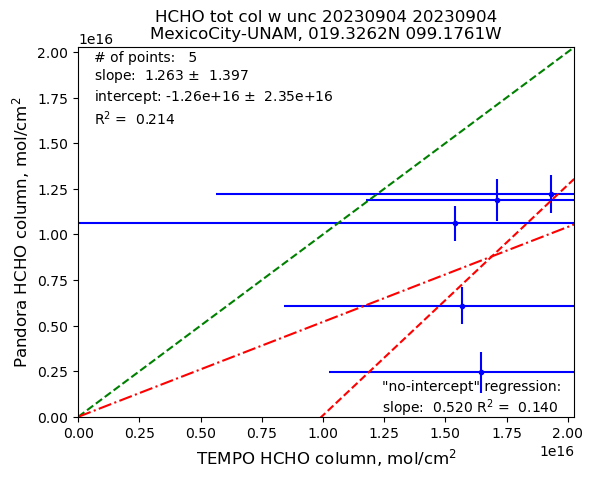

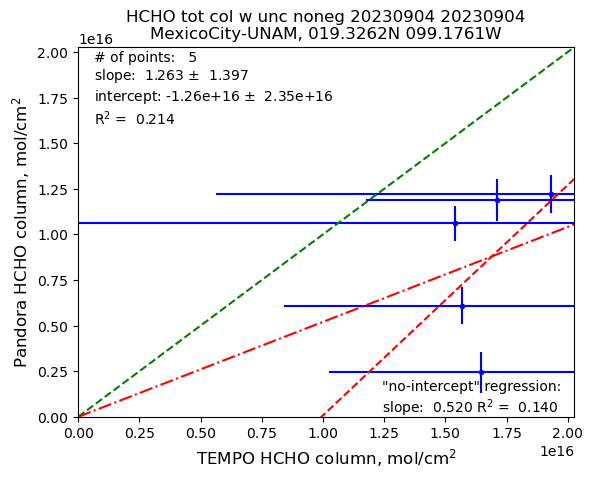

In [41]:
# Plotting scatter plot for all retrievals
# (negative values have not been discarded in processing)
TEMPO_Pandora_scatter = np.empty([0, 4])
for td in time_series_TEMPO:
  for pd in timeseries_Pandora_TEMPO:
    if td[0] == pd[0]:
      TEMPO_Pandora_scatter = np.append(TEMPO_Pandora_scatter,[[td[1], pd[1], td[2], pd[2]]], axis = 0)
      break

if len(TEMPO_Pandora_scatter) < 2:
  print('TEMPO and Pandora time series has less than 2 simultaneous measurements.\n'\
+'Potential causes for this problem is scarcity of TEMPO pixels with QF == 0\n'\
+'and Pandora measurements.\n'\
+'The TEMPO science team recommends using only data with QF == 0.\n'\
+'Users may overcome the restriction on the quality flag set in section 5.3,\n'\
+'find "total_HCHO_column_QF_loc == 0" there. By doing so, users assume risks of using low quality data.\n'\
+'There is nothing to plot here, this block is terminated.')
  sys.exit()

regress = stats.linregress(TEMPO_Pandora_scatter[:, 0], TEMPO_Pandora_scatter[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept =\
 regress_0intercept(TEMPO_Pandora_scatter[:, 0]\
                  , TEMPO_Pandora_scatter[:, 1])

plot_title = out_Q.replace('_',' ')+' w unc '+datestamp_ini+' '+datestamp_fin+'\n'+POI_name
img_name = 'scatter_'+out_Q+'_unc_'+'_'+datestamp_ini+'_'\
+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(TEMPO_Pandora_scatter[:, 0], TEMPO_Pandora_scatter[:, 1],\
xerr=TEMPO_Pandora_scatter[:, 2], yerr=TEMPO_Pandora_scatter[:, 3],\
c = 'b', ls = '', marker = ".")

plt.xlabel(r'TEMPO HCHO column, mol/cm$^{2}$', fontsize=12)
plt.ylabel(r'Pandora HCHO column, mol/cm$^{2}$', fontsize=12)

fig.text(0.15, 0.72,\
f'# of points: {len(TEMPO_Pandora_scatter):3d}\nslope: {slope: 6.3f} $\pm$ {stderr:6.3f}\nintercept: {intercept: 8.2e} $\pm$ {intercept_stderr: 8.2e}\nR$^{2}$ = {r2:6.3f}')

# Set the range of x-axis
l_lim = min(0., min(TEMPO_Pandora_scatter[:, [0,1]].flatten()))*1.05
u_lim = max(TEMPO_Pandora_scatter[:, [0,1]].flatten())*1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim],\
c = 'g', ls = '--')

plt.plot([l_lim, u_lim], [l_lim*slope+intercept, u_lim*slope+intercept],\
c = 'r', ls = '--')

if success:
  plt.plot([l_lim, u_lim], [l_lim*slope_0intercept, u_lim*slope_0intercept], c = 'r', ls = '-.')
  fig.text(0.6, 0.12, f'"no-intercept" regression:\nslope: {slope_0intercept: 6.3f} R$^{2}$ = {r2_0intercept:6.3f}')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

# Plotting scatter plot for positive retrievals
TEMPO_Pandora_scatter_noneg = np.empty([0, 4])
for td in time_series_TEMPO_noneg:
  for pd in timeseries_Pandora_TEMPO_noneg:
    if td[0] == pd[0]:
      TEMPO_Pandora_scatter_noneg = np.append(TEMPO_Pandora_scatter_noneg,[[td[1], pd[1], td[2], pd[2]]], axis = 0)
      break

regress = stats.linregress(TEMPO_Pandora_scatter_noneg[:, 0], TEMPO_Pandora_scatter_noneg[:, 1])
slope = regress.slope
intercept = regress.intercept
r2 = regress.rvalue**2
stderr = regress.stderr
intercept_stderr = regress.intercept_stderr

success, slope_0intercept, r2_0intercept =\
 regress_0intercept(TEMPO_Pandora_scatter_noneg[:, 0]\
                  , TEMPO_Pandora_scatter_noneg[:, 1])

plot_title = out_Q.replace('_',' ')+' w unc noneg '+datestamp_ini+' '+datestamp_fin+'\n'+POI_name
img_name = 'scatter_'+out_Q+'_unc_noneg_'+'_'+datestamp_ini+'_'\
+datestamp_fin+'_'+POI_name+'.jpg'

fig = plt.figure()

plt.errorbar(TEMPO_Pandora_scatter_noneg[:, 0], TEMPO_Pandora_scatter_noneg[:, 1],\
xerr=TEMPO_Pandora_scatter_noneg[:, 2], yerr=TEMPO_Pandora_scatter_noneg[:, 3],\
c = 'b', ls = '', marker = ".")

plt.xlabel(r'TEMPO HCHO column, mol/cm$^{2}$', fontsize=12)
plt.ylabel(r'Pandora HCHO column, mol/cm$^{2}$', fontsize=12)

fig.text(0.15, 0.72,\
f'# of points: {len(TEMPO_Pandora_scatter_noneg):3d}\nslope: {slope: 6.3f} $\pm$ {stderr:6.3f}\nintercept: {intercept: 8.2e} $\pm$ {intercept_stderr: 8.2e}\nR$^{2}$ = {r2:6.3f}')

# Set the range of x-axis
l_lim = 0.
u_lim = max(TEMPO_Pandora_scatter_noneg[:, [0,1]].flatten())*1.05
plt.xlim(l_lim, u_lim)
plt.ylim(l_lim, u_lim)

plt.plot([l_lim, u_lim], [l_lim, u_lim],\
c = 'g', ls = '--')

plt.plot([l_lim, u_lim], [l_lim*slope+intercept, u_lim*slope+intercept],\
c = 'r', ls = '--')

if success:
  plt.plot([l_lim, u_lim], [l_lim*slope_0intercept, u_lim*slope_0intercept], c = 'r', ls = '-.')
  fig.text(0.6, 0.12, f'"no-intercept" regression:\nslope: {slope_0intercept: 6.3f} R$^{2}$ = {r2_0intercept:6.3f}')

plt.title(plot_title+str(', %08.4fN %08.4fW' %(POI[0], -POI[1])))
plt.savefig(img_name, format='jpg', dpi=300)

# EXTRA. Archiving output files to make downloading easier

In [1]:
import zipfile
import glob

In [87]:
list_jpg = glob.glob('*'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'.jpg')

with zipfile.ZipFile('fig_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name+'.zip', 'w') as fig_zip:
  for name in list_jpg: fig_zip.write(name)

In [88]:
list_data = glob.glob('*'+datestamp_ini+'_'+datestamp_fin+'_'+POI_name+'*.txt')

with zipfile.ZipFile('data_'+datestamp_ini+'_'+datestamp_fin+'_'\
+POI_name+'.zip', 'w') as data_zip:
  for name in list_data: data_zip.write(name)

In [2]:
list_jpg = glob.glob('*.jpg')

with zipfile.ZipFile('fig_all_HCHO.zip', 'w') as fig_zip:
  for name in list_jpg: fig_zip.write(name)

list_jpg = glob.glob('*.png')

with zipfile.ZipFile('fig_all_HCHO.zip', 'a') as fig_zip:
  for name in list_jpg: fig_zip.write(name)